# Figure 1: $K$-means data partitions

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import load_digits

from code.blocks import data_preprocessing
from code.utils.visualization import plot_data

data = load_digits()   # Loading MNIST data

In [ ]:
X = data_preprocessing(data)
plot_data(X)

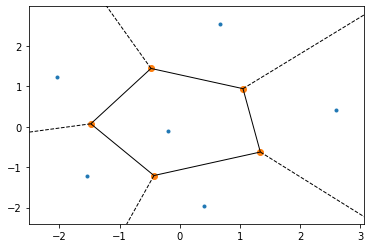

In [12]:
from code.utils.visualization import plot_voronoi_cells
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, n_init=100, random_state=2019).fit(X)
plot_voronoi_cells(X, kmeans)

# Figure 3: SOM training

In [15]:
%%time
from som import SOM

nEpochs = 10
N = len(X)
l = int( ( 5*(N)**(1/2) )**(1/2) ) # side of square grid

som = SOM(l,l)
som.fit(X, alpha0=0.2, sigma0=4, nEpochs=nEpochs, saveNeuronsHist=True)

CPU times: total: 938 ms
Wall time: 933 ms


In [17]:
from IPython.core.display import display, HTML

n_images = 4
epochs = np.linspace(0, nEpochs, num=n_images, dtype='int').tolist()
print(epochs)

# epoch = 30
connections = som.getConnections()

for epoch in epochs:
    display(HTML('<center><h1>Epoch #{}</h1></center>'.format(epoch)))

    # make figure
    fig_dict = {"data": [],"layout": {}}


    # data points
    datapoints = go.Scatter(
        x = X[:,0], 
        y = X[:,1], 
        mode='markers', 
        name='data',
        marker = dict(
            size = 6,
            color = '#03A9F4'
        )
    )
    fig_dict["data"].append(datapoints)


    temp_x = [som.neuronsHist[epoch][idx,0].tolist() + [None] for idx in connections]
    x = [item for sublist in temp_x for item in sublist] # list of lists to list
    temp_y = [som.neuronsHist[epoch][idx,1].tolist() + [None] for idx in connections]
    y = [item for sublist in temp_y for item in sublist]

    data_dict = {
        "x": x,
        "y": y,
        "mode": "lines+markers",
        "marker": {
            "size": 12,
            "color": '#673AB7'
        },
        "line": {"width": 1.5},
        "name": "neurons"
    }
    fig_dict["data"].append(data_dict)


    fig = go.Figure(fig_dict)

    fig.update_layout(
        margin=dict(l=20, r=2, t=2, b=0),
    #         paper_bgcolor="LightSteelBlue",
    #         plot_bgcolor='rgba(0,0,0,0)',
        font=dict(size=12),
    #     xaxis=dict(showgrid=False),
    #     yaxis=dict(showgrid=True),
        autosize=False,
        width  = 1600/2,
        height = 900/2,
    )

    fig.update_layout(legend=dict(x=.8825, y=1))

    fig.show()
    
    display(HTML('<hr>'))
    
    fig.write_image("/home/romulo/Dropbox/Mestrado/Dissertation/dissertacao_latex/images/"+
                    "chap2_som_train_epoch{}.pdf".format(epoch))

[0, 3, 6, 10]


C:\Users\Renan\AppData\Local\Temp\ipykernel_16372\3252584293.py:1: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



AttributeError: 'SOM' object has no attribute 'getConnections'

# Figure 4: Different decision boundaries depending on the kernel of the LSSVM

In [ ]:
# making moons
# from sklearn.datasets import make_moons
# X, labels = make_moons(n_samples=1000, noise=.075, random_state=2019)

import numpy as np

n_samples = 1000
n_p_class = int(n_samples/2)
x1 = np.linspace(0, 3*np.pi, n_p_class)
x2 = np.sin(x1)

sigma = 0.2
np.random.seed(2019)
X_0 = np.column_stack((x1,x2))       + np.random.normal(0, sigma, (n_p_class,2))
X_1 = np.column_stack((x1+.5,x2-1.75)) + np.random.normal(0, sigma, (n_p_class,2))

X = np.concatenate((X_0, X_1), axis=0)
labels = np.array([0]*int(n_samples/2) + [1]*int(n_samples/2)).reshape(-1,1)

# scaling features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
X = scaler.fit_transform(X)

In [ ]:
from lssvm import LSSVM

# maximums and minimus of plot
x_max, y_max = np.amax(X, axis=0)*1.1
x_min, y_min = np.amin(X, axis=0)*1.1


# fitting set of models
from sklearn.svm import SVC
from copy import copy

variations = [
    {'kernel': 'linear'},
#     {'kernel': 'poly', 'd': 2},
    {'kernel': 'poly', 'd': 3},
#     {'kernel': 'poly', 'd': 4},
    {'kernel': 'poly', 'd': 5},
#     {'kernel': 'poly', 'd': 6},
#     {'kernel': 'poly', 'd': 7},
#     {'kernel': 'poly', 'd': 8},
#     {'kernel': 'poly', 'd': 9},
#     {'kernel': 'poly', 'd': 10}
    {'kernel': 'rbf',  'sigma': 1},
]

clfs = [LSSVM(**params) for params in variations]
for clf in clfs: clf.fit(X, labels)
    

In [ ]:
# coloring grid
n = 300 # number of points in each dimension
size = 2 # size of points in the coloring grid

x = np.linspace(x_min, x_max, int(n*16/9))
y = np.linspace(y_min, y_max, n)
# creating the coloring grid data points
xv, yv = np.meshgrid(x, y)
x = xv.flatten()
y = yv.flatten()

X_mgrid = np.column_stack((x, y))

grid_pred = [clf.predict( X_mgrid ) for clf in clfs]

In [ ]:
for i in range(len(variations)):
    print(
        str(variations[i])[1:-1].replace("'", "").replace(": ","_").replace(", ","__")
    )

In [ ]:
# plotting
import plotly.graph_objects as go
from IPython.core.display import display, HTML

# count=0
# for clf in clfs:
for i in range(len(variations)):
    display(HTML('<center><h1>{}</h1></center>'.format(variations[i])))
        
    fig = go.Figure()
    
#     [
#         '#1f77b4',  # muted blue
#         '#ff7f0e',  # safety orange
#         '#2ca02c',  # cooked asparagus green
#         '#d62728',  # brick red
#         '#9467bd',  # muted purple
#         '#8c564b',  # chestnut brown
#         '#e377c2',  # raspberry yogurt pink
#         '#7f7f7f',  # middle gray
#         '#bcbd22',  # curry yellow-green
#         '#17becf'   # blue-teal
#     ]
   
#     grid_pred = clf.predict( X_mgrid )
    
    colors = ['#d62728' if temp==0 else '#1f77b4' for temp in grid_pred[i].tolist()]

    # coloring grid (coloring the regions)
    fig.add_trace(go.Scatter(
        x = x.tolist(),
        y = y.tolist(),
        mode='markers',
        showlegend=False,
        opacity=0.3,
        marker = dict( 
            size=size,
#             color = grid_pred[count]
            color=colors
        )
    ))

    
    # Class A points
    fig.add_trace(go.Scatter(
        x=X[labels.reshape(-1) == 0, 0], 
        y=X[labels.reshape(-1) == 0, 1], 
        mode='markers',
        name='Class A',
        marker = dict(
            size = 7, 
            line = dict(width=1.5,color='#000000'),
            color = "#d62728"
        )
    ))
    
    # Class B points
    fig.add_trace(go.Scatter(
        x=X[labels.reshape(-1) == 1, 0], 
        y=X[labels.reshape(-1) == 1, 1],
        name='Class B',
        mode='markers',
        marker = dict(
            size = 7, 
            line = dict(width=1.5,color='#000000'),
            color = '#1f77b4'
        )
    ))

    # adjusting limits of plot
    fig.update_xaxes(range=[x_min, x_max])
    fig.update_yaxes(range=[y_min, y_max])

    fig.update_layout(
        margin=dict(l=25, r=2, b=5, t=20),
        font=dict(size=12),
        autosize=False,
        width  = 1600/2,
        height = 900/2
    )

    fig.update_xaxes(showgrid=False, zeroline=False)
    fig.update_yaxes(showgrid=False, zeroline=False)

    fig.update_layout(legend=dict(x=.89, y=1))
    
    # fig.update_layout({
    # #     'title': 'MNIST data set after PCA (2 components)'
    # })

    fig.show(renderer="png")
    
    name = str(variations[i])[1:-1].replace("'", "").replace(": ","_").replace(", ","__")
    
    fig.write_image("/home/romulo/Dropbox/Mestrado/Dissertation/dissertacao_latex/images/"+
                    "chap2_lssvm_{}.pdf".format(name))
    
    display(HTML('<hr>'))
#     break

print('DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!')